# 0. Setup

In [33]:
# Import Packages
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import shapely
from shapely import wkt
import statistics
import matplotlib.pyplot as plt
import zipfile

# Import sklearn modelling packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Import performance metrics
from sklearn.metrics import (mean_absolute_error as mae, mean_squared_error as mse, 
                             explained_variance_score as evs, r2_score as r2)                # Regression
from sklearn.metrics import (accuracy_score as acc, balanced_accuracy_score as bal_acc, 
                             f1_score as f1, roc_auc_score as roc_auc,
                             average_precision_score as ave_prec)                            # Classification
def mape(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [2]:
# Ignore Warnings
import warnings

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Assumptions
rs=42

sd_thresh = 1

# 1. Import and split data

## 1.1 Import

In [4]:
# Import Data
data_11 = pd.read_csv('C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\ML Gentrification Prediction\\Inputs\\Cleaned Dataset/Data_11_SEIFA_FINAL_GH.csv')
data_16 = pd.read_csv('C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\ML Gentrification Prediction\\Inputs\\Cleaned Dataset/Data_16_SEIFA_FINAL_GH.csv')

## 1.2 Data split (80/20 ratio)

In [6]:
# Split data into training/test/validation
train, test = train_test_split(data_11, test_size = 0.2, random_state = rs)

# Split into X and Y
x_train = train.iloc[:,2:-14]  # Not including walkability metrics
y_train = train.iloc[:,-1]

x_test = test.iloc[:,2:-14]  # Not including walkability metrics
y_test = test.iloc[:,-1]

# 2. Build untuned RF model

## 2.1 Fit basic RF

In [7]:
# Import necessary packages
rf = RandomForestRegressor(random_state=42)

In [11]:
# Fit basic RF model
rf_model = rf.fit(x_train, y_train)

# Fit prediction to test dataset
y_pred_rf = rf_model.predict(x_test)

## 2.2 Evaluate Performance - Based on SEIFA Score

In [264]:
# Calculate metrics
mae_rf = mae(y_test, y_pred_rf)
mse_rf = mse(y_test, y_pred_rf)
evs_rf = evs(y_test, y_pred_rf)
r2_rf = r2(y_test, y_pred_rf)
mape_rf = mape(y_test, y_pred_rf)

print(f"mae_rf: {mae_rf}, \nmse_rf: {mse_rf}, \nevs_rf: {evs_rf}, \nr2_rf: {r2_rf}, \nmape_rf: {mape_rf}")

mae_rf: 20.851262959472198, 
mse_rf: 835.8057996229971, 
evs_rf: 0.9230943566373822, 
r2_rf: 0.9230851348190279, 
mape_rf: 2.087094270530973


## 2.3 Evaluate Performance - Based on Predicted Rank

In [26]:
test_rf = test

## Actual Rank Change
# Calculate the rank of each irsad_score within year
seq_11 = sorted(test_rf['irsad_score_11'])
index_11 = [seq_11.index(v) for v in test_rf['irsad_score_11']]

seq_16 = sorted(test_rf['irsad_score_16'])
index_16 = [seq_16.index(v) for v in test_rf['irsad_score_16']]

# Merge rank back onto main dataset
test_rf['SEIFA_rank_11'] = index_11
test_rf['SEIFA_rank_16'] = index_16

# Calculate change in rank:
test_rf['SEIFA_rc_actual'] = test_rf['SEIFA_rank_16'] - test_rf['SEIFA_rank_11']


## RF Predicted Rank Change
test_rf['SEIFA_16_rf'] = y_pred_rf
seq_16_rf = sorted(test_rf['SEIFA_16_rf'])
index_16_rf = [seq_16_rf.index(v) for v in test_rf['SEIFA_16_rf']]

# Merge rank back onto main dataset
test_rf['SEIFA_rank_16_rf'] = index_16_rf

# Calculate change in rank:
test_rf['SEIFA_rc_rf'] = test_rf['SEIFA_rank_16_rf'] - test_rf['SEIFA_rank_11']

In [24]:
# Create rank vectors
rank_test = test_rf['SEIFA_rank_16']
rank_pred_rf = test_rf['SEIFA_rank_16_rf']

# Calculate metrics
mae_rf_rank = mae(rank_test, rank_pred_rf)
mse_rf_rank = mse(rank_test, rank_pred_rf)
evs_rf_rank = evs(rank_test, rank_pred_rf)
r2_rf_rank = r2(rank_test, rank_pred_rf)
mape_rf_rank = mape(rank_test, rank_pred_rf)

print(f"mae_rf_rank: {mae_rf_rank}, \nmse_rf_rank: {mse_rf_rank}, \nevs_rf_rank: {evs_rf_rank}, \
      \nr2_rf_rank: {r2_rf_rank}, \nmape_rf_rank: {mape_rf_rank}")

mae_rf_rank: 122.53722902921771, 
mse_rf_rank: 29163.693685202637, 
evs_rf_rank: 0.9221578780292822,       
r2_rf_rank: 0.9221337576040473, 
mape_rf_rank: 21.332448709162477


## 2.4 Evaluate Performance - Based on Gentrification Flag

*Gentrification

In [37]:
# Calculate standard deviation of rank change
sd_rc = statistics.stdev(test_rf['SEIFA_rc_actual'])
sd_rc_rf = statistics.stdev(test_rf['SEIFA_rc_rf'])

# Create new column flagging gentrification
test_rf['gentrification_flag'] = np.where(test_rf['SEIFA_rc_actual'] > sd_thresh * sd_rc, 1, 0)
test_rf['gentrification_flag_rf'] = np.where(test_rf['SEIFA_rc_rf'] > sd_thresh * sd_rc_rf, 1, 0)

In [38]:
# Define actual and predicted vectors
gent_test = test_rf['gentrification_flag']
gent_pred_rf = test_rf['gentrification_flag_rf']

# Calculate classification performance scores
acc_rf_gent = acc(gent_test, gent_pred_rf)
bal_acc_rf_gent = bal_acc(gent_test, gent_pred_rf)
f1_rf_gent = f1(gent_test, gent_pred_rf)
roc_auc_rf_gent = roc_auc(gent_test, gent_pred_rf)
ave_prec_rf_gent = ave_prec(gent_test, gent_pred_rf)

print(f"acc_rf_gent: {acc_rf_gent}, \nbal_acc_rf_gent: {bal_acc_rf_gent}, \nf1_rf_gent: {f1_rf_gent}, \
      \nroc_auc_rf_gent: {roc_auc_rf_gent}, \nave_prec_rf_gent: {ave_prec_rf_gent}")

acc_rf_gent: 0.8572101790763431, 
bal_acc_rf_gent: 0.7131685107445497, 
f1_rf_gent: 0.4873096446700507,       
roc_auc_rf_gent: 0.7131685107445497, 
ave_prec_rf_gent: 0.3014544530269073


# 3. Hyperparameter tuning

Now I will be performing the hyperparameter tuning of the RF model. The hyperparameters that I will tune include:

- n_estimators
- max_features
- max_depth
- min_samples_split
- min_samples_leaf
- bootstrap

I will first use a randomised search to narrow down the hyperparameter space using a randomised grid. I will then perform a grid search to evaluate the specific best set of hyperparameters. 

## 3.1 Use RandomisedSearchCV() to narrow down hyperparameter space

### 3.1.1 Tune using RandomisedSearchCV()

In [12]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter space
max_depth = np.arange(10, 110,10)
max_features = np.arange(10, 100,10)
n_estimators = np.arange(start=200, stop=2001, step=100)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

# Create randomised search
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, 
                               verbose=2, 
                               random_state=rs, 
                               n_jobs = -1)

{'n_estimators': array([ 200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100, 1200,
       1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]), 'max_features': array([10, 20, 30, 40, 50, 60, 70, 80, 90]), 'max_depth': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [13]:
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 129.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 234.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                                        'max_features': array([10, 20, 30, 40, 50, 60, 70, 80, 90]),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100, 1200,
       1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000])},
                   random_state=42, verbose=2)

In [14]:
print("The best RCV parameters are %s with a score of %0.4f"
     % (rf_random.best_params_, rf_random.best_score_))

The best RCV parameters are {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 20, 'max_depth': 90, 'bootstrap': False} with a score of 0.9317


## 3.2 Define best RF Model

In [39]:
# Define RF with best parameters from RandomisedSearchCV()
rf_rcv = RandomForestRegressor(random_state=42, 
                               n_estimators = 1600, 
                               min_samples_split = 5,
                               min_samples_leaf=4,
                               max_features=20,
                               max_depth=90,
                               bootstrap=False)

# Fit RCV model
rf_rcv_model = rf_rcv.fit(x_train, y_train)

# Fit prediction to test dataset
y_pred_rf_rcv = rf_rcv_model.predict(x_test)

## 3.3 Evaluate Performance of tuned RF

### 3.3.1 Performance based on SEIFA index

In [40]:
# Calculate metrics - SEIFA Score
mae_rf_rcv = mae(y_test, y_pred_rf_rcv)
mse_rf_rcv = mse(y_test, y_pred_rf_rcv)
evs_rf_rcv = evs(y_test, y_pred_rf_rcv)
r2_rf_rcv = r2(y_test, y_pred_rf_rcv)
mape_rf_rcv = mape(y_test, y_pred_rf_rcv)

print(f"mae_rf_rcv: {mae_rf_rcv}, \nmse_rf_rcv: {mse_rf_rcv}, \nevs_rf_rcv: {evs_rf_rcv}, \nr2_rf_rcv: {r2_rf_rcv}, \nmape_rf_rcv: {mape_rf_rcv}")

mae_rf_rcv: 19.58761390286752, 
mse_rf_rcv: 730.5817361424763, 
evs_rf_rcv: 0.932768564997855, 
r2_rf_rcv: 0.93276835867324, 
mape_rf_rcv: 1.9587885198863109


### 3.3.2 Performance based on gentrification flag

In [45]:
## Calculate gentrification flag
test_rf_rcv = test

# rf_rcv Predicted Rank Change
test_rf_rcv['SEIFA_16_rf_rcv'] = y_pred_rf_rcv
seq_16_rf_rcv = sorted(test_rf_rcv['SEIFA_16_rf_rcv'])
index_16_rf_rcv = [seq_16_rf_rcv.index(v) for v in test_rf_rcv['SEIFA_16_rf_rcv']]

# Merge rank back onto main dataset
test_rf_rcv['SEIFA_rank_16_rf_rcv'] = index_16_rf_rcv

# Calculate change in rank:
test_rf_rcv['SEIFA_rc_rf_rcv'] = test_rf_rcv['SEIFA_rank_16_rf_rcv'] - test_rf_rcv['SEIFA_rank_11']

# Calculate standard deviation of rank change
sd_rc_rf_rcv = statistics.stdev(test_rf_rcv['SEIFA_rc_rf_rcv'])

# Create new column flagging gentrification
test_rf_rcv['gentrification_flag_rf_rcv'] = np.where(test_rf_rcv['SEIFA_rc_rf_rcv'] > sd_thresh * sd_rc_rf_rcv, 1, 0)

In [46]:
# Define actual and predicted vectors
gent_pred_rf_rcv = test_rf_rcv['gentrification_flag_rf_rcv']

# Calculate classification perf_rcvormance scores
acc_rf_rcv_gent = acc(gent_test, gent_pred_rf_rcv)
bal_acc_rf_rcv_gent = bal_acc(gent_test, gent_pred_rf_rcv)
f1_rf_rcv_gent = f1(gent_test, gent_pred_rf_rcv)
roc_auc_rf_rcv_gent = roc_auc(gent_test, gent_pred_rf_rcv)
ave_prec_rf_rcv_gent = ave_prec(gent_test, gent_pred_rf_rcv)

print(f"acc_rf_rcv_gent: {acc_rf_rcv_gent}, \nbal_acc_rf_rcv_gent: {bal_acc_rf_rcv_gent}, \nf1_rf_rcv_gent: {f1_rf_rcv_gent}, \
      \nroc_auc_rf_rcv_gent: {roc_auc_rf_rcv_gent}, \nave_prec_rf_rcv_gent: {ave_prec_rf_rcv_gent}")

acc_rf_rcv_gent: 0.8656927426955702, 
bal_acc_rf_rcv_gent: 0.7348507311287629, 
f1_rf_rcv_gent: 0.5210084033613445,       
roc_auc_rf_rcv_gent: 0.734850731128763, 
ave_prec_rf_rcv_gent: 0.3305852046347057


# 4. Use tuned model to predict 2021 Gentrification locations

## 4.1 Define 'x' dataset for 2016, predict 2021 SEIFA scores

In [272]:
# Define 'x' data
X_16 = data_16.iloc[:,1:-1]

# Define new dataset to store results in:
data_16_rf = data_16

# Fit model to 2016 input data to predict 2021 SEIFA scores
data_16_rf['Predicted_SEIFA_21'] = rf_model.predict(X_16)

## 4.2 Calculate change in rank for each SA1 area

In [332]:
# Calculate the rank of each irsad_score within year
seq_16 = sorted(data_16_rf['irsad_score'])
index_16 = [seq_16.index(v) for v in data_16_rf['irsad_score']]

seq_21 = sorted(data_16_rf['Predicted_SEIFA_21'])
index_21 = [seq_21.index(v) for v in data_16_rf['Predicted_SEIFA_21']]

# Merge rank back onto main dataset
data_16_rf['SEIFA_rank_16'] = index_16
data_16_rf['SEIFA_rank_21'] = index_21

# Calculate change in rank:
data_16_rf['SEIFA_rank_change'] = data_16_rf['SEIFA_rank_21'] - data_16_rf['SEIFA_rank_16']


## Calculate standard deviation of rank change
# Standard Deviation:
sd_rc = statistics.stdev(data_16_rf['SEIFA_rank_change'])

# Bin data into SD rank change:
data_16_rf['SEIFA_bins'] = pd.cut(x=data_16_rf['SEIFA_rank_change'], \
                                   bins=[-10*sd_rc,-4*sd_rc, -2*sd_rc, -0.9*sd_rc, 0.9*sd_rc, 2*sd_rc, 4*sd_rc, 10*sd_rc],\
                                   labels = ['< -4', '-4 - -2', '-2 - -1', '-1 - 1', '1 - 2', '2 - 4', '> 4'])

# Create subset of observations within +/- 1 SD for visualisation:
data_16_rf_sd1 = data_16_rf.loc[(data_16_rf['SEIFA_rank_change'] < 0.9*sd_rc) & \
                                (data_16_rf['SEIFA_rank_change'] > (-0.9*sd_rc) ) ]

## 4.3 Get Sydney subset for cleaner visualisation

In [307]:
# Import sa1 boundaries
with zipfile.ZipFile("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data/1270055001_sa1_2016_aust_shape.zip","r") as zip_ref:
    zip_ref.extractall("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data")
    
gdf_sa1 = gpd.read_file("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data/SA1_2016_AUST.shp")

gdf_sa1.SA1_MAIN16 = gdf_sa1.SA1_MAIN16.astype("int64")


# Import sa3 boundaries
with zipfile.ZipFile("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data/1270055001_sa3_2016_aust_shape.zip","r") as zip_ref:
    zip_ref.extractall("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data")
    
gdf_sa3 = gpd.read_file("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data/SA3_2016_AUST.shp")

gdf_sa3.SA3_NAME16 = gdf_sa3.SA3_NAME16.astype("str")

In [333]:
# Sydney Subset
sa3_syd = ["Eastern Suburbs - North", "Eastern Suburbs - South",
           "Botany", "Sydney Inner City", "Marrickville - Sydenham - Petersham",
           "Leichhardt", "Kogarah - Rockdale", "Canterbury",
           "Hurstville", "Strathfield - Burwood - Ashfield","Canada Bay",
           "Bankstown", "Auburn", "Merrylands - Guildford", "Cronulla - Miranda - Caringbah",
           "Sutherland - Menai - Heathcote", "Campbelltown (NSW)", "Liverpool", "Fairfield",
           "Parramatta", "Blacktown", "Mount Druitt", "Blacktown - North",
           "Baulkham Hills", "Carlingford", "Ryde - Hunters Hill", "North Sydney - Mosman",
           "Chatswood - Lane Cove", "Manly", "Ku-ring-gai", "Warringah",
           "Warringah", "Hornsby", "Dural - Wisemans Ferry", "Pittwater", "Rouse Hill - McGraths Hill",
           "Campbelltown (NSW)", "Camden", "Bringelly - Green Valley", "Penrith",
           "St Marys", "Richmond - Windsor", "Pennant Hills - Epping"]

subset_syd = gdf_sa1[gdf_sa1.SA3_NAME16.isin(sa3_syd)]

# Get unique SA1_Codes 
mylist_syd = list(set(subset_syd.SA1_MAIN16))


# Subset to sydney datasets
gdf_sa3_syd = gdf_sa3[gdf_sa3.SA3_NAME16.isin(sa3_syd)]


# Subset SEIFA dataset to Sydney
data_16_rf_syd = data_16_rf[data_16_rf.SA1_MAIN16.isin(mylist_syd)]
data_16_rf_syd_sd1 = data_16_rf_sd1[data_16_rf_sd1.SA1_MAIN16.isin(mylist_syd)]

## 4.4 Visualise predicted gentrification hotspots

In [334]:
# Merge shapefile to data frame
sa1_rf_syd = gdf_sa1.merge(data_16_rf_syd, on = "SA1_MAIN16")
sa1_rf_syd_sd1 = gdf_sa1.merge(data_16_rf_syd_sd1, on = "SA1_MAIN16")

### 4.4.1 Visualise predicted distribution of SEIFA 2021 throughout Sydney

### 4.4.2 Visualise change in SEIFA rank 2016-2021

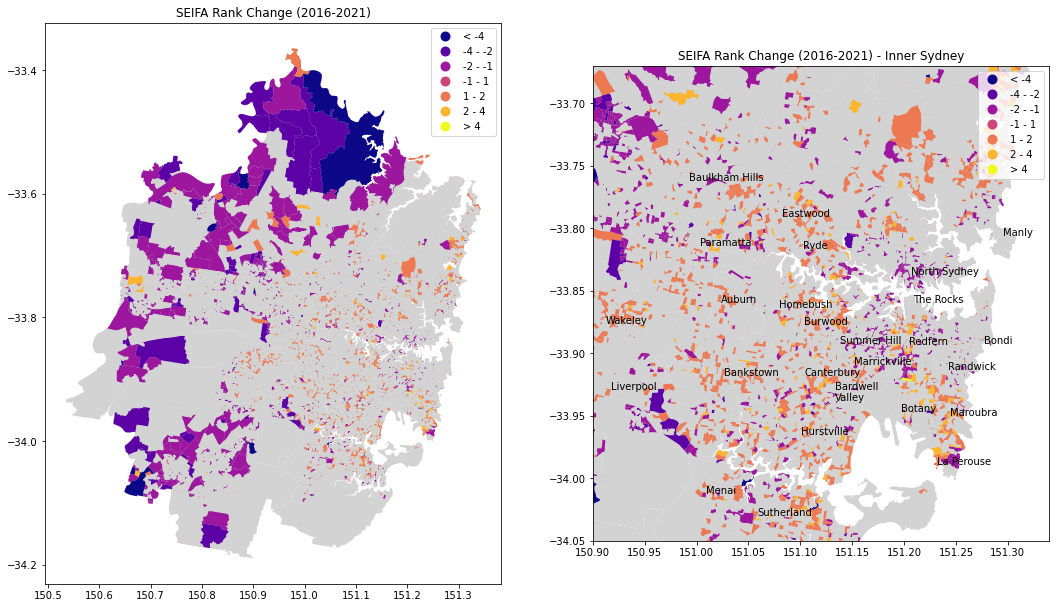

In [337]:
# Visualise SIEFA Rank Change coverage
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 12))

gdf_sa3_syd.plot(color='lightgrey', ax=axes[0])
sa1_rf_syd.plot(column='SEIFA_bins', cmap="plasma", ax=axes[0], legend=True)
sa1_rf_syd_sd1.plot(color='lightgrey', edgecolor='lightgrey', ax=axes[0])
ax=axes[0].set(title='SEIFA Rank Change (2016-2021)')

gdf_sa3_syd.plot(color='lightgrey', ax=axes[1])
sa1_rf_syd.plot(column='SEIFA_bins', cmap="plasma", ax=axes[1], legend=True)
sa1_rf_syd_sd1.plot(color='lightgrey', edgecolor='lightgrey', ax=axes[1])
ax=axes[1].set(title='SEIFA Rank Change (2016-2021) - Inner Sydney')
ax=axes[1].set_xlim([150.9, 151.34])
ax=axes[1].set_ylim([-34.05, -33.67])
ax=axes[1].text(151.152, -33.909, 'Marrickville'); ax=axes[1].text(151.277, -33.892, 'Bondi'); 
ax=axes[1].text(151.295, -33.806, 'Manly'); ax=axes[1].text(151.197, -33.947, 'Botany'); 
ax=axes[1].text(151.205, -33.893, 'Redfern'); ax=axes[1].text(151.133, -33.938, 'Bardwell\nValley');
ax=axes[1].text(151.104, -33.918, 'Canterbury'); ax=axes[1].text(151.103, -33.816, 'Ryde'); 
ax=axes[1].text(151.232, -33.989, 'La Perouse'); ax=axes[1].text(151.244, -33.950, 'Maroubra'); 
ax=axes[1].text(151.003, -33.814, 'Paramatta'); ax=axes[1].text(151.138, -33.892, 'Summer Hill'); 
ax=axes[1].text(151.059, -34.030, 'Sutherland'); ax=axes[1].text(151.101, -33.965, 'Hurstville'); 
ax=axes[1].text(150.918, -33.929, 'Liverpool'); ax=axes[1].text(151.207, -33.837, 'North Sydney'); 
ax=axes[1].text(151.009, -34.012, 'Menai'); ax=axes[1].text(150.993, -33.762, 'Baulkham Hills'); 
ax=axes[1].text(151.209, -33.859, 'The Rocks'); ax=axes[1].text(151.242, -33.913, 'Randwick');

ax=axes[1].text(151.026, -33.918, 'Bankstown'); ax=axes[1].text(151.0236, -33.859, 'Auburn');
ax=axes[1].text(151.082, -33.7904, 'Eastwood'); ax=axes[1].text(151.0796, -33.863, 'Homebush');
ax=axes[1].text(150.912, -33.876, 'Wakeley'); ax=axes[1].text(151.104, -33.877, 'Burwood');